<a href="https://colab.research.google.com/github/Bryce-R/ML/blob/master/SimpleDecoderTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import math
from tqdm.auto import tqdm

# set random seed
random.seed(42)
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device ", device)

Using device  cuda


In [37]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.ln1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
        )
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        # Casual self-attention
        attn_out, _ = self.self_attn(x, x, x, attn_mask=mask)
        x = self.ln1(x + attn_out)

        ff_out = self.ff(x)
        x = self.ln2(x + ff_out)
        return x


class TinyDecoderOnlyTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, n_heads=4, d_ff=1024, n_layers=4, seq_len=2048):
        super().__init__()
        self.vocab_size = vocab_size # Store vocab_size
        self.seq_len = seq_len # Store seq_len
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(seq_len, d_model)

        self.blocks = nn.ModuleList([
            DecoderBlock(d_model, n_heads, d_ff) for _ in range(n_layers)
        ])

        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, idx):
        B, T = idx.shape
        pos = torch.arange(T, device=idx.device)
        x = self.token_emb(idx) + self.pos_emb(pos)

        # Causal mask: (T, T)
        mask = torch.triu(torch.ones(T, T, device=idx.device), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        # print(f"mask", mask)

        for block in self.blocks:
            x = block(x, mask)

        x = self.ln_f(x)
        logits = self.head(x)
        return logits

    @torch.no_grad()
    def generate(self, idx, max_new_tokens):
        # idx is (B, T)
        for _ in range(max_new_tokens):
            # Crop idx to the last seq_len tokens if it exceeds
            idx_cond = idx if idx.shape[1] <= self.seq_len else idx[:, -self.seq_len:]

            # Get predictions
            logits = self(idx_cond)
            # Focus only on the last time step
            logits = logits[:, -1, :]
            # Apply softmax to get probabilities
            # probs = F.softmax(logits, dim=-1)
            # Sample the next token with highest probability (greedy sampling)
            # idx_next = torch.multinomial(probs, num_samples=1)
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

            # Append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [38]:

# Example usage
vocab = 50
model = TinyDecoderOnlyTransformer(vocab, d_model=8, n_heads=4, d_ff=32, n_layers=2)
# model = TinyDecoderOnlyTransformer(vocab, d_model=128, n_heads=4, d_ff=512, n_layers=2)
model.to(device)
idx = torch.randint(0, vocab, (2, 10), device=device)  # batch=2, seq_len=32
logits = model(idx)
print(logits.shape)  # (2, 32, vocab)


torch.Size([2, 10, 50])


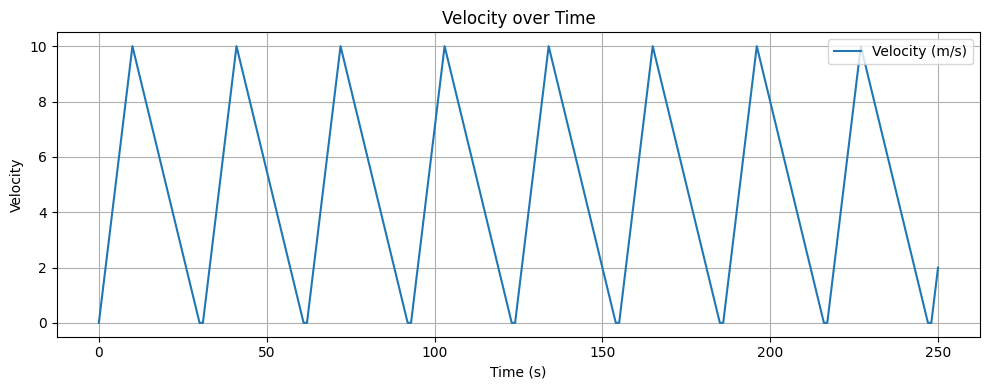

torch.Size([1, 501, 1])


In [31]:
def plot_sequence(sequence):
    velocity = sequence[:, 0]
    time = torch.arange(sequence.size(0)) * 0.5

    plt.figure(figsize=(10, 4))
    plt.plot(time, velocity, label='Velocity (m/s)')
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity')
    plt.title('Velocity over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
def generate_velocity_sequence(seq_length):

    velocity = 0.0
    sequence = [ [velocity] ]
    state = 'up'  # 'up', 'down', 'stop'
    stop_counter = 0

    for _ in range(seq_length):
        if state == 'up':
            velocity += 0.5
            if velocity >= 10.0:
                velocity = 10.0
                state = 'down'
        elif state == 'down':
            velocity -= 0.25
            if velocity <= 0.0:
                velocity = 0.0
                state = 'stop'
                stop_counter = 0
        elif state == 'stop':
            stop_counter += 1
            if stop_counter >= 2:
                state = 'up'

        sequence.append([velocity])

    return torch.tensor(sequence, dtype=torch.float32)


# x = generate_velocity_sequence(500).unsqueeze(0)  # Single sequence of length 50
x = generate_velocity_sequence(500).unsqueeze(0)  # Single sequence of length 50
# Plot the sequence
plot_sequence(x[0]) # [B, T, dim]
print(x.shape)

In [32]:
class VelocityTokenizer:
    def __init__(self, min_val=0.0, max_val=10.0, vocab_size=50):
        self.min_val = min_val
        self.max_val = max_val
        self.vocab_size = vocab_size
        # Calculate bin width to include both min and max values within the vocab_size range
        self.bin_width = (max_val - min_val) / (vocab_size - 1)

    def tokenize(self, velocity_sequence):
        # Ensure values are within min_val and max_val
        clipped_sequence = torch.clamp(velocity_sequence, self.min_val, self.max_val)
        # Scale to 0 to (vocab_size - 1) range
        scaled_sequence = (clipped_sequence - self.min_val) / self.bin_width
        # Round to nearest integer and convert to long for token IDs
        tokens = torch.round(scaled_sequence).long()
        return tokens

    def detokenize(self, tokens):
        # Convert tokens back to scaled values
        scaled_values = tokens.float() * self.bin_width + self.min_val
        return scaled_values

# Example usage with the generated sequence 'x'
# 'vocab' variable is already defined globally in your notebook as 50
vocab = 50
tokenizer = VelocityTokenizer(vocab_size=vocab)

# Tokenize the velocity sequence 'x'
tokenized_x = tokenizer.tokenize(x)

# Squeeze the last dimension to match the transformer's expected input shape (B, T)
tokenized_x_for_transformer = tokenized_x.squeeze(-1)

print(f"Original sequence shape: {x.shape}")
print(f"Tokenized sequence shape: {tokenized_x.shape}")
print(f"Tokenized sequence for transformer shape (B, T): {tokenized_x_for_transformer.shape}")
print(f"First 10 original velocity values (batch 0):")
for i in range(10):
    print(f"  {x[0, i, 0].item():.2f}")
print(f"First 10 tokenized values (batch 0):")
print(f"  {tokenized_x_for_transformer[0, :10].tolist()}")

print(f"Maximum token value: {tokenized_x_for_transformer.max().item()}")
print(f"Minimum token value: {tokenized_x_for_transformer.min().item()}")

# Verify detokenization (optional, for checking accuracy)
detokenized_x = tokenizer.detokenize(tokenized_x)
print(f"\nDetokenized sequence shape: {detokenized_x.shape}")
print(f"Original vs Detokenized (first 10 values, batch 0):")
for i in range(10):
    print(f"  Original: {x[0, i, 0].item():.2f}, Detokenized: {detokenized_x[0, i, 0].item():.2f}")


Original sequence shape: torch.Size([1, 501, 1])
Tokenized sequence shape: torch.Size([1, 501, 1])
Tokenized sequence for transformer shape (B, T): torch.Size([1, 501])
First 10 original velocity values (batch 0):
  0.00
  0.50
  1.00
  1.50
  2.00
  2.50
  3.00
  3.50
  4.00
  4.50
First 10 tokenized values (batch 0):
  [0, 2, 5, 7, 10, 12, 15, 17, 20, 22]
Maximum token value: 49
Minimum token value: 0

Detokenized sequence shape: torch.Size([1, 501, 1])
Original vs Detokenized (first 10 values, batch 0):
  Original: 0.00, Detokenized: 0.00
  Original: 0.50, Detokenized: 0.41
  Original: 1.00, Detokenized: 1.02
  Original: 1.50, Detokenized: 1.43
  Original: 2.00, Detokenized: 2.04
  Original: 2.50, Detokenized: 2.45
  Original: 3.00, Detokenized: 3.06
  Original: 3.50, Detokenized: 3.47
  Original: 4.00, Detokenized: 4.08
  Original: 4.50, Detokenized: 4.49


Epoch 0, Step 0, Loss 4.003856182098389
Epoch 10, Step 0, Loss 3.073462963104248
Epoch 20, Step 0, Loss 2.16036319732666
Epoch 30, Step 0, Loss 1.2417521476745605
Epoch 40, Step 0, Loss 0.6877267360687256
Epoch 50, Step 0, Loss 0.3859173059463501
Epoch 60, Step 0, Loss 0.2340593934059143
Epoch 70, Step 0, Loss 0.14361818134784698
Epoch 80, Step 0, Loss 0.08868075907230377
Epoch 90, Step 0, Loss 0.05942331254482269
Epoch 100, Step 0, Loss 0.043356429785490036
Epoch 110, Step 0, Loss 0.0324820801615715
Epoch 120, Step 0, Loss 0.027209686115384102
Epoch 130, Step 0, Loss 0.041416965425014496
Epoch 140, Step 0, Loss 0.03017788752913475
Epoch 150, Step 0, Loss 0.03725927695631981
Epoch 160, Step 0, Loss 0.03640390560030937
Epoch 170, Step 0, Loss 0.03913607448339462
Epoch 180, Step 0, Loss 0.04105071350932121
Epoch 190, Step 0, Loss 0.036750759929418564


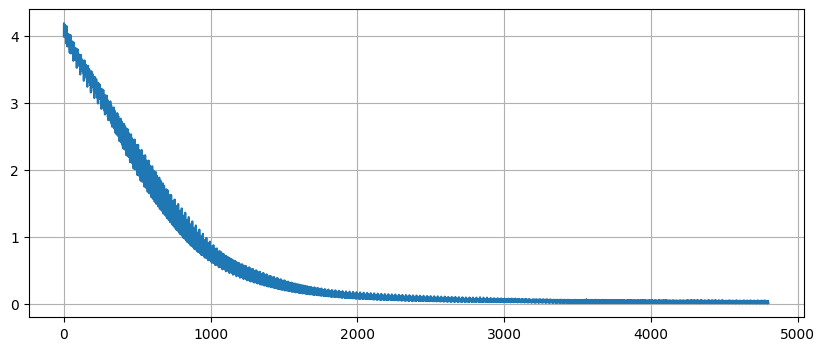

In [52]:


seq_len = 30
model = TinyDecoderOnlyTransformer(vocab, d_model=8, n_heads=4, d_ff=32, n_layers=2, seq_len=seq_len)
model.to(device)
history_len = 10
step = 50
# x [B, 501, 1]
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

chunk_step = 20

loss_values = []
steps = []

for epoch in range(200):
  for i in range(0, x.shape[1]-seq_len-1, chunk_step):
      x_batch = x[:, i:i+seq_len, :].to(device)
      y_batch = x[:, i+1:i+seq_len+1, :].to(device)
      tokenized_x_batch = tokenizer.tokenize(x_batch)
      tokenized_x_batch_for_transformer = tokenized_x_batch.squeeze(-1)
      tokenized_y_batch = tokenizer.tokenize(y_batch)
      tokenized_y_batch = tokenized_y_batch.squeeze(-1)
      logits = model(tokenized_x_batch_for_transformer)
      loss_value = loss(logits.view(-1, logits.shape[-1]), tokenized_y_batch.view(-1))
      optimizer.zero_grad()
      loss_value.backward()
      optimizer.step()
      loss_values.append(loss_value.item())
      if len(steps) == 0:
        steps.append(0)
      else:
        steps.append(steps[-1] + 1)
      if epoch % 10 == 0 and i == 0:
        print(f"Epoch {epoch}, Step {i}, Loss {loss_value.item()}")

plt.figure(figsize=(10, 4))
plt.plot(steps, loss_values, label='Loss')
plt.grid()

idx tensor([[[2.5000],
         [3.0000],
         [3.5000],
         [4.0000],
         [4.5000]]])
tokenized_idx tensor([[12, 15, 17, 20, 22]], device='cuda:0')
sequence tensor([[12, 15, 17, 20, 22, 24, 27, 26, 24, 27, 29, 32, 34, 33, 32, 31, 29, 28,
         27, 26, 24, 23, 22, 21, 20, 18, 17, 16, 15, 13]], device='cuda:0')
detokenized_sequence [4.897959  5.5102043 5.306123  4.897959  5.5102043 5.9183674 6.5306125
 6.9387755 6.734694  6.5306125 6.326531  5.9183674 5.714286  5.5102043
 5.306123  4.897959  4.6938777 4.489796  4.2857146 4.0816326 3.6734695
 3.4693878 3.2653062 3.0612247 2.6530614]


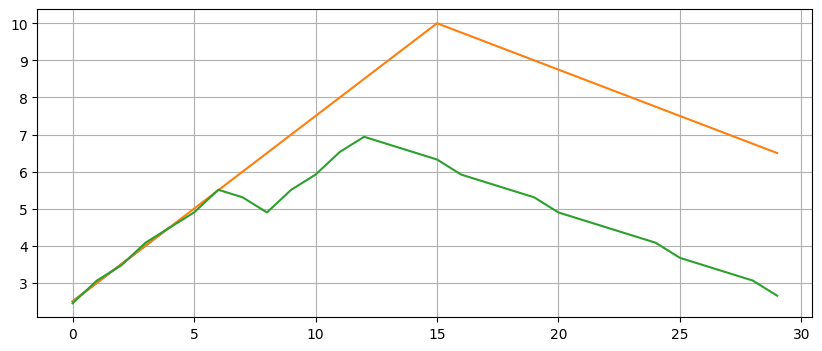

In [54]:
start = 5
end = 10
idx = x[:, start:end, :]
print(f"idx", idx)
tokenized_idx = tokenizer.tokenize(idx).squeeze(-1).to(device)
print(f"tokenized_idx", tokenized_idx)
# print(f"tokenized_idx.shape", tokenized_idx.shape)
sequence = model.generate(tokenized_idx, seq_len-idx.shape[1])
print(f"sequence", sequence)
detokenized_sequence = tokenizer.detokenize(sequence)
print(f"detokenized_sequence", detokenized_sequence.cpu().numpy()[0][5:])

plt.figure(figsize=(10, 4))
plt.plot(idx.cpu().numpy()[0], label='history')
plt.plot(x[:, start:start+seq_len, :].cpu().numpy()[0], label='Original Sequence')
plt.plot(detokenized_sequence.cpu().numpy()[0], label='Generated Sequence')
plt.grid()


